<a href="https://colab.research.google.com/github/shadab4150/Hindi-News-Language-Model-and-Classification-indic-NLP/blob/master/Hindi_News_Language_Model_and_Classification_indic_NLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/Dataset/hindi2vec.zip' -d '/content/'

Archive:  /content/drive/My Drive/Dataset/hindi2vec.zip
   creating: /content/hindi2vec/
  inflating: /content/hindi2vec/bbc-hindi-news.json  
  inflating: /content/hindi2vec/hindi-test.csv  
  inflating: /content/hindi2vec/hindi-train.csv  


In [0]:
from fastai.text import *
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [0]:
df_trn = pd.read_csv('/content/hindi2vec/hindi-train.csv', sep="\t", encoding='utf-8', header=None)
df_val = pd.read_csv('/content/hindi2vec/hindi-test.csv', sep="\t", encoding='utf-8', header=None)
df_val.columns=['category','text']
df_trn.columns=['category','text']

In [17]:
df_trn.head()

,category,text
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [6]:
df_val.head()

,category,text
0,india,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1,india,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2,india,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3,international,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4,india,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...


In [0]:
train = pd.concat([df_trn[['text']],df_val[['text']]])
train.dropna(inplace=True)
train_df = pd.concat([df_trn[['category','text']],df_val[['category','text']]])
train_df.dropna(inplace=True)

In [9]:
print(train.isna().sum())
train.dropna(inplace=True)

text    2
dtype: int64


In [10]:
train.head()

,text
0,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [0]:
bs = 128
path = Path('/content/')

In [5]:
data = (TextList.from_df(train,path=path)
            .split_by_rand_pct(0.2, seed=42)
            .label_for_lm()           
            .databunch(bs=bs, num_workers=1))

In [22]:
data.show_batch(rows=6)

idx,text
0,. मेट्रो के तीसरे xxunk में भारत में पहली बार ड्राइवरलेस तकनीक आएगी लेकिन दुनिया भर में कई देशों में ड्राइवरलेस मेट्रो पहले से ही चलती हैं . इन देशों में ड्राइवरलेस मेट्रो सफल भी रही हैं . दक्षिण कोरिया की राजधानी सोल में xxunk ट्रेन कामयाबी से चल रही है . ये मेट्रो ज़मीन के नीचे चलती है इसमें ड्राइवर का केबिन भी नहीं होता है . यूरोप में
1,करता है . इन ग्राहकों के पास या तो अधिक ताक़तवर इंजन वाली बाइक ख़रीदने का विकल्प है या फिर पुरानी मशीन को अपनी पसंद के मुताबिक xxunk लेने का . इनके सपने भारत की सड़कों पर चलने वाली ज्यादातर 125 सीसी के मोटरसाइकिलों के मालिकों से अलग हैं जिनकी तादाद तक़रीबन एक करोड़ होगी . इन मोटरसाइकिलों की क़ीमत 31 लाख रुपए तक हैं और उनके लिए ये विलासिता
2,"ख़तरे के निशान को पार कर जाएगा . लेकिन उन्होंने इस बात पर जोर दिया था कि यह रेखा वो खुद नहीं बल्कि अंतरराष्ट्रीय समुदाय एक समझौते पर दस्तखत कर खींच रहा है , इसमें कहा गया है कि रासायनिक हथियारों का प्रयोग घृणित है और कांग्रेस इस समझौते को स्वीकार करती है . अमरीका दमिश्क के बाहरी इलाके में 21 अगस्त को हुए रासायनिक हमले के मृतकों की संख्या"
3,"चल गई . फिल्म में रणबीर अच्छे दिखे हैं , अभिनय अच्छा है और डांस भी ऐसा किया है कि दर्शकों का दिल जीत लें . इस नए सुपरस्टार के लिए एक और अवार्ड इंतज़ार कर रहा है . दीपिका का अभिनय भी बढ़िया है . नैना के किरदार में उन्होंने बहुत सारी परतें जोड़ी है जो उनके रोल को दिलचस्प बनाता है . आदित्य एकदम सहज अभिनय करते हैं"
4,"छंट गए , बिचौलियों का सफाया हो गया और सरकार का पैसा बच गया . असल में आधार नंबर हासिल करने और सबकुछ दुरुस्त होने के बाद भी लोगों को समझ नहीं आ रहा कि कहां ग़लती रह गई . अगर आधार की अनिवार्यता समाप्त होती है तो आम लोगों को भारी राहत मिलेगी . ग्राउंड रिपोर्ट : आधार कार्ड होने पर भी झारखंड में नहीं मिल रहा xxunk खेड़ा"
5,की भूमिका निभाएंगे . पवार के बयान ने कांग्रेस और एनसीपी के संबंधों को साफ़ कर दिया है . इससे पहले कयास लगाए जा रहे थे कि वो यूपीए का साथ छोड़कर भारतीय जनता पार्टी की अगुवाई वाले राष्ट्रीय लोकतांत्रिक गठबंधन या एनडीए से नाता जोड़ सकते हैं . पवार ने कहा है कि एनडीए को पूर्ण बहुमत नहीं मिलने जा रहा है और कई ऐसे क्षेत्रीय दल हैं जो


In [36]:
data.vocab.itos[-40:-20]

['टीटीई',
 'पांसे',
 'मोनास्टेरेसे',
 '”कारमेला',
 'स्टम्पिंग',
 'ग़ौस',
 'मधुबनी',
 'पावलो',
 "'वीज़ा",
 'कोविंद',
 'बुकहोल्ज़',
 'छेदना',
 'पद्मावत',
 'कालवी',
 'दिप्रिडिक्टर',
 'रेंस',
 'कार्तिकेयन',
 'इस्लर',
 'वेनेज़ुएला',
 'बॉस्को']

## Mixed Precision Training

In [0]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False,metrics=[accuracy,Perplexity()]).to_fp16()

In [0]:
lr = 1e-2
lr *= bs/48  # Scaling the learning rate by batch size

In [15]:
learn.unfreeze()
learn.fit_one_cycle(15, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.731962,5.313904,0.196456,203.141708,00:35
1,4.814239,4.587552,0.257634,98.253624,00:35
2,4.492496,4.421658,0.266566,83.234138,00:35
3,4.402434,4.390825,0.267863,80.706993,00:36
4,4.317959,4.339634,0.272140,76.679543,00:35
5,4.200906,4.289844,0.278106,72.954987,00:36
6,4.097507,4.251066,0.282893,70.180168,00:36
7,3.984800,4.211158,0.287816,67.434570,00:36
8,3.832767,4.174318,0.291354,64.995422,00:36
9,3.700561,4.152410,0.295367,63.587059,00:36


In [0]:
learn.save('H_Model1')

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


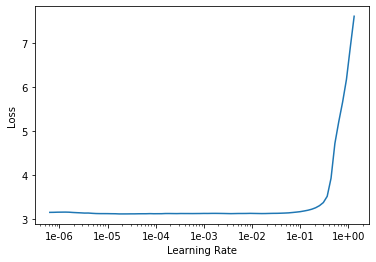

In [17]:
learn.load('H_Model1')
learn.lr_find()
learn.recorder.plot()

In [27]:
gc.collect()

780

In [28]:
learn.load('H_Model1')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.137799,4.158897,0.303195,64.000885,00:36
1,3.149056,4.159355,0.302944,64.030220,00:36
2,3.128989,4.162050,0.302984,64.203087,00:36
3,3.087258,4.165887,0.303100,64.449875,00:36
4,3.084037,4.167521,0.303093,64.555252,00:36


In [0]:
learn.save('final')
learn.save_encoder('ftenc')

In [44]:
gc.collect()

2274

In [0]:
learn.load('/content/models/final');

# Lets try to complete acutual News Headlines

![kd](https://i.ibb.co/0BwNzp7/sdfsfs.jpg)


* Actual New headline from **BBC Hindi**.

* **Three** different Takes

In [55]:
for i in range(3):
  print(learn.predict('सऊदी अरब की जेलों में बंद पाकिस्तानी क़ैदियों की कहानी',n_words=50,temperature=0.75))

सऊदी अरब की जेलों में बंद पाकिस्तानी क़ैदियों की कहानी में भी है . हाल ही में संयुक्त राष्ट्र ने एक रिपोर्ट के आधार पर कहा है कि इस जानकारी के अनुसार ये वाक्यांश अब ज़्यादा पुराना है . और इन क़ैदियों को गवाही देने के लिए बगराम के पास से ही 1920 में हुए ख़ूनी संघर्ष में इनकी संख्या
सऊदी अरब की जेलों में बंद पाकिस्तानी क़ैदियों की कहानी लिखने वाले पाकिस्तान के ख़िलाफ़ अफगानिस्तान में लड़ाई भड़काने वाले सैनिक हमलों के ख़िलाफ़ हैं . तालिबान की पूरी ज़मीन पर हमलों के लिए एक बड़ी साज़िश का आयोजन किया गया है . एक अन्य सैन्य अधिकारी ने कहा है कि ये हमला ईस्ट ईस्ट इंडिया दुनिया भर की ही
सऊदी अरब की जेलों में बंद पाकिस्तानी क़ैदियों की कहानी अपनी एक तस्वीर और एक प्रकाशक के साथ बातचीत कर रही थी . इस घटना को जर्मन ख़ुफ़िया और उसके सहयोगी बताते हैं . इस देश के खनिज सम्मेलन में अब तक सैंकड़ों लोग मारे जा चुके हैं . इन आंकड़ों के बाद शुक्रवार को हुए इस धमाके में एक


![kd](https://i.ibb.co/zhNBv1p/bbcsdf.jpg)

* Actual New headline from **BBC Hindi**.

In [57]:
learn.predict('लंदन: मस्जिद में चाकू से हमला, एक गिरफ़्तार',n_words=50,temperature=0.65)


'लंदन: मस्जिद में चाकू से हमला, एक गिरफ़्तार और दो कांस्टेबल समेत कई लोग घायल हो गए . पुलिस का कहना है कि इस घटना के बाद पुलिस ने थानेदार को गिरफ्तार कर लिया है . पुलिस का कहना है कि बंदूक़धारी के अनुसार चार घायल व्यक्ति फरार हैं . पुलिस के अनुसार पुलिस ने बताया है कि'

In [0]:
learn.export('hindiNews.pkl')

# Hindi News Classifier

In [13]:
train_df.head()

,category,text
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [6]:
data_clas = (TextList.from_df(train_df, path, vocab=data.vocab, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='category')
    .databunch(bs=bs, num_workers=1))

In [16]:
data_clas.show_batch(rows=6)

text,target
xxbos 1920 के दशक में फ़ीफ़ा के अध्यक्ष xxunk रिमे और फ़्रांस के फ़ुटबॉल xxunk ने दुनिया की बेहतरीन फ़ुटबॉल टीम तय करने के लिए प्रतियोगिता कराने का विचार किया . 1929 में फ़ीफ़ा ने एक प्रस्ताव पारित करके विश्व कप फ़ुटबॉल आयोजित कराने का फ़ैसला xxunk में शुरू हुई ये प्रतियोगिता हर चार साल पर आयोजित होती है . दूसरे विश्व युद्ध के कारण 1942 और 1946 में विश्व,sport
"xxbos खिलाड़ियों ने रंगीन पोशाकें पहननी शुरू की , गेंद xxunk हो गई और अंपायर तक रंगीन पोशाक में नज़र आने लगे . मैच दिन - रात के होने लगे और 50 - 50 ओवरों के मैच होने लगे . पहले तीन विश्व कप इंग्लैंड में आयोजित हुए और तीन में दो विश्व कप का ख़िताब वेस्टइंडीज़ ने जीता . लेकिन 1983 का विश्व कप जीतकर भारत ने बड़ा उलटफेर",sport
xxbos शुभ्रांशु चौधरी ने सात वर्षों के लंबे शोध के बाद ये किताब लिखी है . अंग्रेज़ी और हिंदी दोनों भाषाओं में प्रकाशित इस किताब का एक अंश हम अपने पाठकों के लिए प्रकाशित कर रहे हैं . समय जैसे उड़ गया . फिर विदा लेने का समय हो गया . कैंप में सभी कतार बांध कर हाथ मिलाने और लाल सलाम कहने को खड़े हो गए . इस बार,india
"xxbos 1996 में जब राज कपूर के बेटे रणधीर कपूर और बेटी ऋतु नंदा चीन गए तो उनकी आँखों में उस समय आंसू आ गए जब चीनी लोगों ने उन्हें देखते ही ' आवारा हूँ ' गाने लगते . उन्हें ये नहीं पता था कि ये दोनों राज कपूर के बेटे बेटी थे , लेकिन वो ये गीत गा कर राज कपूर और भारत का सम्मान कर रहे थे .",entertainment
xxbos भारत विभाजन के 70 साल होने पर मैं अपनी मां को भारत ले जाना चाहता था ताकि मेरी 80 साल की मां xxunk हमदानी xxunk में अपना पुराना घर देख सकें . दूसरी ओर मेरी साथी इशलीन कौर को अपने दादा सरदार उजागर सिंह को पाकिस्तान ले जाना था . 89 साल के उजागर सिंह लायलपुर से भारत चले गए थे . लेकिन न तो मुझे और मेरी मां,international
"xxbos उस ज़माने में भारतीय टीम में एक - दो अच्छे खिलाड़ी ज़रूर थे लेकिन उन्हें जीत का स्वाद चखने की आदत नहीं पड़ी थी . तेज़ गेंदबाज़ी का आलम ये था कि विकेटकीपर रहे xxunk xxunk पहला ओवर फेंका करते थे . किसी रणनीति के तहत नहीं , बल्कि इसलिए कि पूरी टीम में कोई तेज़ गेंदबाज़ था ही नहीं . 'एक आंख , एक पैर ' से xxunk",india


### News Categories

In [60]:
data_clas.classes

['business',
 'china',
 'entertainment',
 'india',
 'institutional',
 'international',
 'learningenglish',
 'multimedia',
 'news',
 'pakistan',
 'science',
 'social',
 'southasia',
 'sport']

## Metrics f1_score

* Because there is a class imbalance in the dataset
> average = **macro**

In [0]:
f2 = FBeta()
f2.average='macro'

In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False , drop_mult=0.5, metrics=[accuracy,f2]).to_fp16()
learn_c.load_encoder('ftenc')
learn_c.freeze()

In [0]:
lr=2e-2
lr *= bs/48

In [22]:
learn_c.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.418805,0.952847,0.690531,0.670485,00:24
1,1.069217,0.808977,0.718245,0.710587,00:23
2,0.915867,0.855018,0.697460,0.679505,00:23
3,0.795260,0.700155,0.771363,0.770147,00:23
4,0.716566,0.723106,0.752887,0.745949,00:25
5,0.639550,0.744450,0.757506,0.756467,00:26
6,0.584152,0.677333,0.766744,0.762378,00:24
7,0.512121,0.683973,0.766744,0.762855,00:24
8,0.451812,0.703521,0.775982,0.773055,00:24
9,0.405528,0.697988,0.771363,0.768272,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


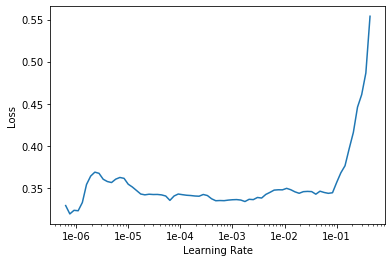

In [42]:
learn_c.save('clf')
learn_c.load('clf')
learn_c.unfreeze()
learn_c.lr_find()
learn_c.recorder.plot()

In [43]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.342958,0.693506,0.773672,0.770535,00:23
1,0.340611,0.698785,0.773672,0.770659,00:23
2,0.338841,0.702812,0.771363,0.768271,00:26
3,0.340626,0.712110,0.769053,0.766652,00:26
4,0.335852,0.702011,0.769053,0.766010,00:24


In [25]:
txt_interp = TextClassificationInterpretation.from_learner(learn_c)

In [26]:
txt_interp.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
xxbos ख़बरों के मुताबिक़ सुपरस्टार अमिताभ बच्चन और आमिर ख़ान मुंबई के वानखेड़े स्टेडियम में होने वाले सचिन तेंदुलकर के आख़िरी टेस्ट मैच के दौरान मौजूद रहेंगे . लेकिन इस तमाम हंगामे में क्रिकेट के ज़बरदस्त प्रशंसक और आईपीएल की कोलकाता नाइट राइडर्स टीम के मालिक शाहरुख़ ख़ान के xxunk ही रहने की संभावना है . क्योंकि वो एक बैन की वजह से वानखेड़े स्टेडियम में प्रवेश नहीं कर सकते,sport,entertainment,8.07,0.00
"xxbos अकेले हीथ्रो हवाई अड्डे पर एक लाख 16 हज़ार यात्री आने वाले हैं . इस हवाई अड्डे ने 31 काउंटर का एक नया अस्थाई गेम्स टर्मिनल खोला है . उधर xxunk हवाई अड्डे पर 70 हज़ार यात्री आने की उम्मीद है जिनमें दो सौ चीनी एथलीट भी शामिल होंगे . कनाडा , पोलैंड और ऑस्ट्रिया के खिलाड़ी सबसे पहले अपने वतन लौटे हैं . xxunk हवाई अड्डे की एक",international,sport,7.54,0.00
"xxbos एक अख़बार के मुताबिक पीड़िता के भाई ने आसाराम के बयान पर कहा "" हमारे मन में आसाराम के लिए बहुत सम्मान था पर उन्होंने बेहद ही बेतुकी बात कही है . हमारे घर में उनकी कुछ किताबें रखी हैं जो मैं दिल्ली जाते ही जला xxunk . ""बीबीसी ने आसाराम के कुछ अनुयायियों से बात करके जानने कि कोशिश की अपने गुरु के इस वक्तव्य से उनकी आस्था",india,entertainment,7.42,0.00
xxbos बीबीसी संवाददाता xxunk xxunk के अनुसार तमिलनाडु के वन अधिकारियों को चिंता है कि हाथियों की xxunk के ज़रिए आशीर्वाद देने की इस परंपरा से हाथी बीमार पड़ सकते हैं . तमिलनाडु के मंदिरों में लगभग 50 हाथी है और उन्हें xxunk से तीर्थ यात्रियों के सिर को छूने के लिए मजबूर किया जाता है . वन अधिकारियों का कहना है कि तीर्थ यात्रियों को छूने से हाथियों को,news,science,6.91,0.00
"xxbos “ तेरे आने की जब खबर xxunk , तेरी xxunk से सारा घर xxunk xxunk तेरे xxunk से , शाम के बाद फिर सहर xxunk . xxunk बचपन की xxunk की जगह रूमानियत जैसे नए जज़्बात ले हे थे . वो जज़्बात जो नए थे , समझ में आते भी थे और नहीं भी , xxunk , xxunk . न जाने ऐसे कितने ही लोग होंगे जिनकी xxunk दिल",india,entertainment,6.62,0.00


In [0]:
learn_c.save('clf')
learn_c.load('clf')
learn_c.unfreeze()

## Training the last few layers

In [45]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.543069,0.795909,0.743649,0.745619,00:24
1,0.543387,0.637044,0.775982,0.769791,00:24
2,0.416708,0.653791,0.778291,0.773739,00:24


In [46]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.307337,0.775218,0.764434,0.762449,00:23
1,0.244670,0.730185,0.780600,0.779123,00:24


In [61]:
learn_c.unfreeze()
learn_c.fit_one_cycle(3, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.134255,0.766814,0.782910,0.777803,00:25
1,0.137570,0.789495,0.780600,0.777579,00:25
2,0.123060,0.809372,0.792148,0.789989,00:23


# final f_beta score 0.789

# Saving fp32 version

In [0]:
learn.to_fp32().save('/content/hindi_model/hindiM1', with_opt=False)
learn.data.vocab.save('/content/hindi_model/HindiVocab.pkl')